# Projeto Final

Curso: Python - Turma: 63730

Professor: Grabriel Rodrigues

Aluno: Francis Martins Vieira

Tema: APIs IBGE, localidade, nome e frequência
Objetivo: Realizar extração e tratamento dos dados para que seja possível analisar e obter informações sobre o nomes com maior registro no Pais ao longo das décadas e o consolidado geral por estado.

I - Instalação do requirements.txt

In [1]:
#Preparando ambiente recursos mínimos necessários para execução do Projeto
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


II - Importação de bibliotecas

In [2]:
# importando bibliotecas gerais para uso ao longo do desenvolvimento do Projeto
import pandas as pd
import requests

# importando biblitotecas para mensagem de Alerta
from plyer import notification
from datetime import datetime

# importando biblioteca para apoio em validação campos vazios nos dataframe
import missingno as msno

# importanto biblioteca relacionado ao Banco de Dados
import sqlite3

III - Criação de Alerta com nofificação

In [3]:
# Criando Alerta com notification.notify definido anteriormente
# detalhamento das definições do Alerta
def Alerta_default(text1):
    vNow = str(datetime.now())
    text1 = "Falha ao acessar API"
    msg_texto = f"Erro! {text1} \nOcorrência: {vNow}"

    if text1 == 1:
        text1 = "Falha ao ler API"
    else:
        print("Erro desconhecido!",text1)

    notification.notify(
            title=text1,
            message=msg_texto,
            app_name='Alerta!',
            timeout=10
                        )

IV - Extração e refinamento dos dados

In [4]:
# 1º acervo de informações obtido via API
# Utilizando consumo da API para leitura dos dados
# API IBGE - v1/localidades/estados
api_estado = "https://servicodados.ibge.gov.br/api/v1/localidades/estados" #para teste do Alerta alterado versão da API: "https://servicodados.ibge.gov.br/api/v3/localidades/estados"
response = requests.get(api_estado)
if response.status_code == 200:
    dados_json = response.json()
else:
    Alerta_default(1)

# Converter dados em Data Frame
base_estado = pd.DataFrame(dados_json)

# Expandindo a coluna 'regiao' para detalhar o seu conteúdo em colunas separadas
base_regiao_detalhada = base_estado['regiao'].apply(pd.Series)
base_regiao_detalhada.columns = ['regiao_id', 'regiao_sigla', 'regiao_nome']

# Concatenando os DataFrames
df_estado = pd.concat([base_estado.drop(columns=['regiao']), base_regiao_detalhada], axis=1)

# Exibir o DataFrame 
df_estado

,id,sigla,nome,regiao_id,regiao_sigla,regiao_nome
0,11,RO,Rondônia,1,N,Norte
1,12,AC,Acre,1,N,Norte
2,13,AM,Amazonas,1,N,Norte
3,14,RR,Roraima,1,N,Norte
4,15,PA,Pará,1,N,Norte
5,16,AP,Amapá,1,N,Norte
6,17,TO,Tocantins,1,N,Norte
7,21,MA,Maranhão,2,NE,Nordeste
8,22,PI,Piauí,2,NE,Nordeste
9,23,CE,Ceará,2,NE,Nordeste


In [5]:
# 2º acervo de informações obtido via API
# Utilizando consumo da API para leitura dos dados
# API IBGE - v2/censos/nomes/ranking?localidade={id}
api_ranking_nomes = "https://servicodados.ibge.gov.br/api/v2/censos/nomes/ranking?localidade=" #Utilizado para testar o Alerta alterar a versão da API "https://servicodados.ibge.gov.br/api/v4/censos/nomes/ranking?localidade=" ***IMPORTANTE**** a quantidade de Alerta vai ser a mesma quantidade de 'id' do dataframe df_estado (um alerta por cada chamada)
dados_api_ranking = []

# Fazendo chamadas de API para cada 'id' na coluna do DataFrame df_estado e armazenando os resultados
# Iterar sobre a coluna 'id' do DataFrame
for id in df_estado['id']:
    api_ranking_id = api_ranking_nomes + str(id)
    response = requests.get(api_ranking_id)
    if response.status_code == 200:
        ranking_id = response.json()
        # laço criado utilizando a estrutura dos dados em uma lista com as chaves 'nome', 'frequencia' e 'ranking'
        for item in ranking_id:
            for temp in item['res']:
                dados_api_ranking.append({
                    'localidade_id': id,
                    'nome': temp['nome'],
                    'frequencia': temp['frequencia'],
                    'ranking': temp['ranking']
                })
    else:
        Alerta_default(1)

# Converter a lista de dados em um DataFrame
df_ranking = pd.DataFrame(dados_api_ranking)

# Exibir o DataFrame
df_ranking


,localidade_id,nome,frequencia,ranking
0,11,MARIA,72579,1
1,11,JOSE,37986,2
2,11,JOAO,23366,3
3,11,ANA,20134,4
4,11,ANTONIO,16252,5
...,...,...,...,...
535,53,FRANCISCA,11858,16
536,53,BRUNO,10753,17
537,53,EDUARDO,10332,18
538,53,LUIS,10291,19


In [6]:
# 3º acervo de informações obtido via API
# Utilizando consumo da API para leitura dos dados
# API IBGE - v2/censos/nomes/{nome}

# Criando uma Função para que seja possível fazer as chamadas da API usando os valores únicos da coluna 'nome' do DataFrame df_ranking
# definido função buscar_nomes
def buscar_nomes(freq_nome):
    url_api = "https://servicodados.ibge.gov.br/api/v2/censos/nomes/" #Utilizado para testar o Alerta alterar a versão da API "https://servicodados.ibge.gov.br/api/v5/censos/nomes/" ***IMPORTANTE**** a quantidade de Alerta vai ser a mesma quantidade de 'nomes' únicos do dataframe df_ranking (um alerta por cada chamada)
    nomes_unicos = freq_nome['nome'].drop_duplicates()
    resultados = []

# criando for para montar a url da api
    for nome in nomes_unicos:
        url_nova = url_api + nome
        response = requests.get(url_nova)
        if response.status_code == 200:
            data = response.json()
            for temp in data:
                busca = {
                    'nome': nome,
                    'sexo': temp.get('sexo', ''),
                    'localidade': temp.get('localidade', '')
                }
                for periodo in temp.get('res', []):
                    col_frequencia = f"frequencia {periodo['periodo']}"
                    busca[col_frequencia] = periodo['frequencia']
                resultados.append(busca)
        else:
            Alerta_default(1)

    return pd.DataFrame(resultados)

# Chamando a função para obter os dados
df_nomes = buscar_nomes(df_ranking)

# Adicionando uma nova coluna em df_nomes com o total geral por nome
df_nomes['total_frequencia'] = df_nomes.filter(like='frequencia').sum(axis=1)

# Exibir o DataFrame com resultado
df_nomes


,nome,sexo,localidade,frequencia 1930[,"frequencia [1930,1940[","frequencia [1940,1950[","frequencia [1950,1960[","frequencia [1960,1970[","frequencia [1970,1980[","frequencia [1980,1990[","frequencia [1990,2000[","frequencia [2000,2010[",total_frequencia
0,MARIA,None,BR,336477,749053,1487042,2476482,2495491,1616019,917968,544296,1111301,11734129
1,JOSE,None,BR,118121,311202,648754,1082782,1242231,942212,661123,431536,316568,5754529
2,JOAO,None,BR,60155,141772,256001,396438,429148,279975,273960,352552,794118,2984119
3,ANA,None,BR,33395,56160,101259,183941,292835,421531,529266,536302,935169,3089858
4,ANTONIO,None,BR,60651,153459,314375,490645,531596,421292,299788,181350,123192,2576348
5,FRANCISCO,None,BR,33338,78300,160721,263616,331643,298780,285827,195901,124071,1772197
6,PAULO,None,BR,6234,20739,60073,163158,264587,274744,259594,211265,162868,1423262
7,LUCAS,None,BR,388,937,1593,2787,4425,9954,84484,517436,505306,1127310
8,CARLOS,None,BR,4659,15620,53410,154038,267228,258333,270843,198370,266690,1489191
9,MARCOS,None,BR,777,2182,8840,38435,137775,256225,241551,219198,201182,1106165


V - Validação se há ocorrência de valores nulo e removendo caso exista

<Axes: >

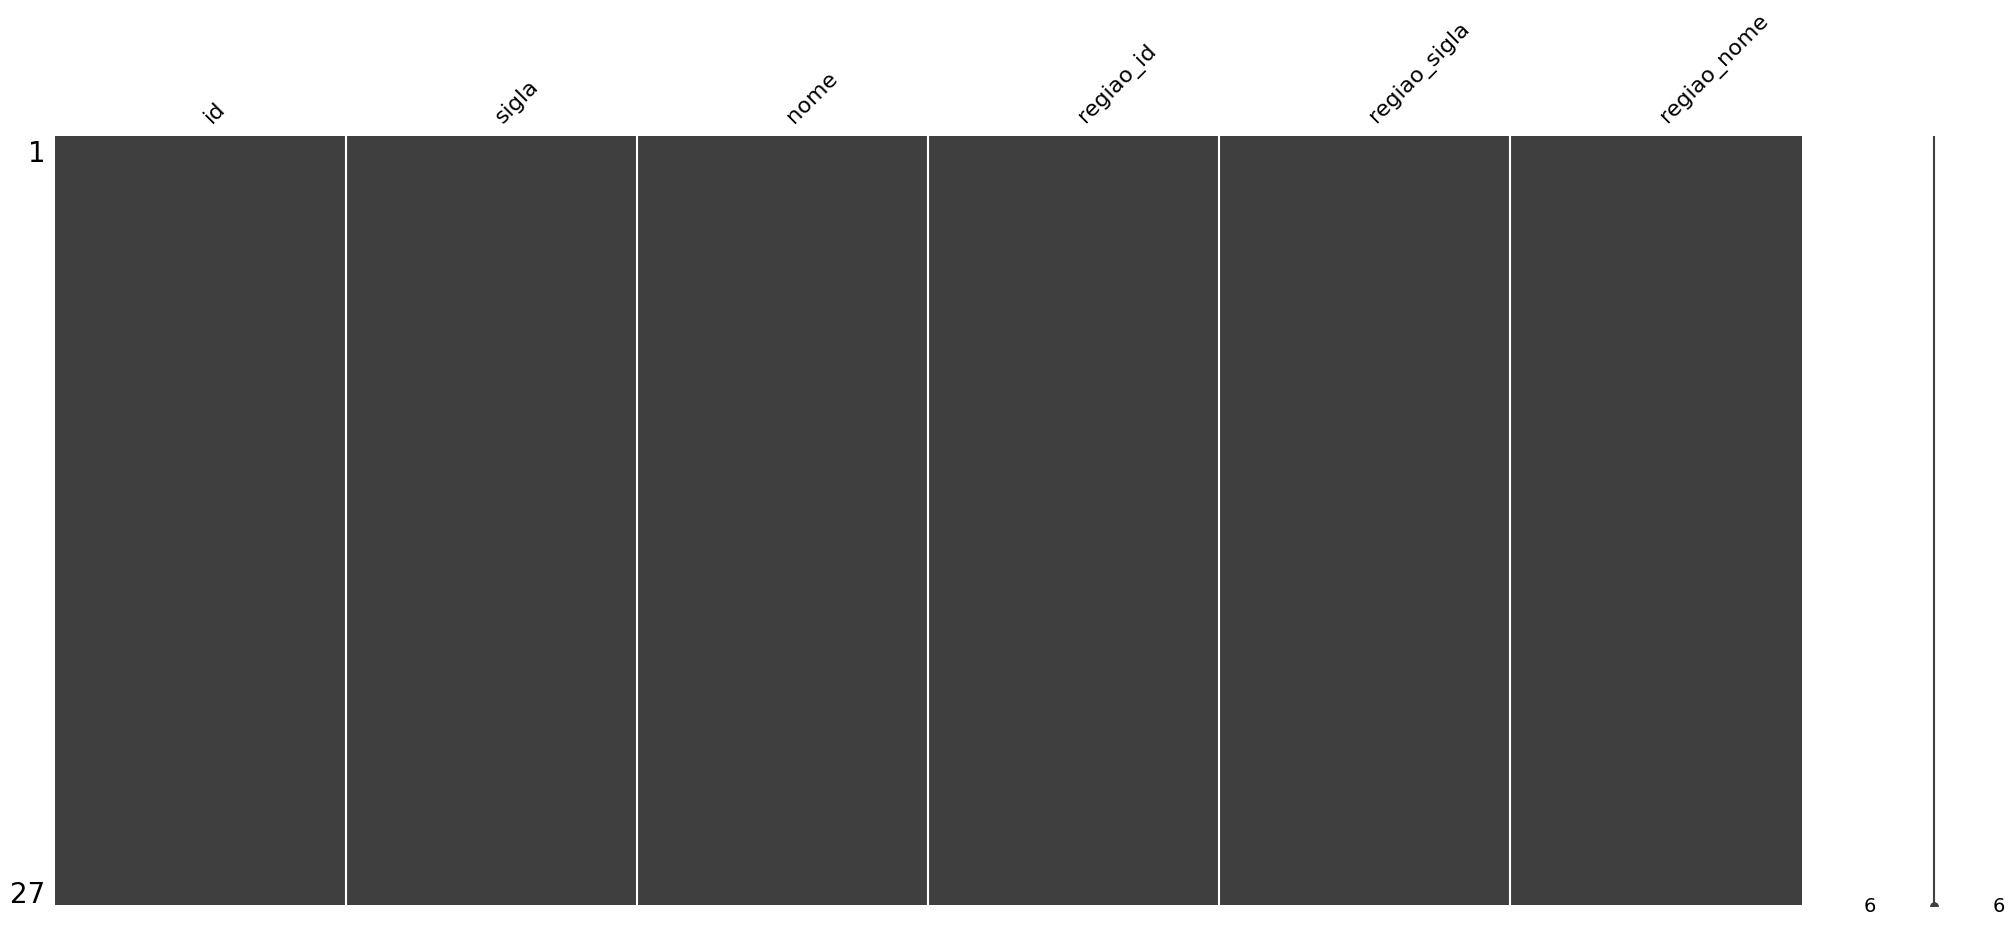

In [7]:
# Verificando se há ocorrência de campos com valores nulos
# Foi escolhido utilizar a biblioteca missingno para essa finalidade, devido a praticidade de visualização.

#Validar conteúdo dataframe df_estado
msno.matrix(df_estado)

<Axes: >

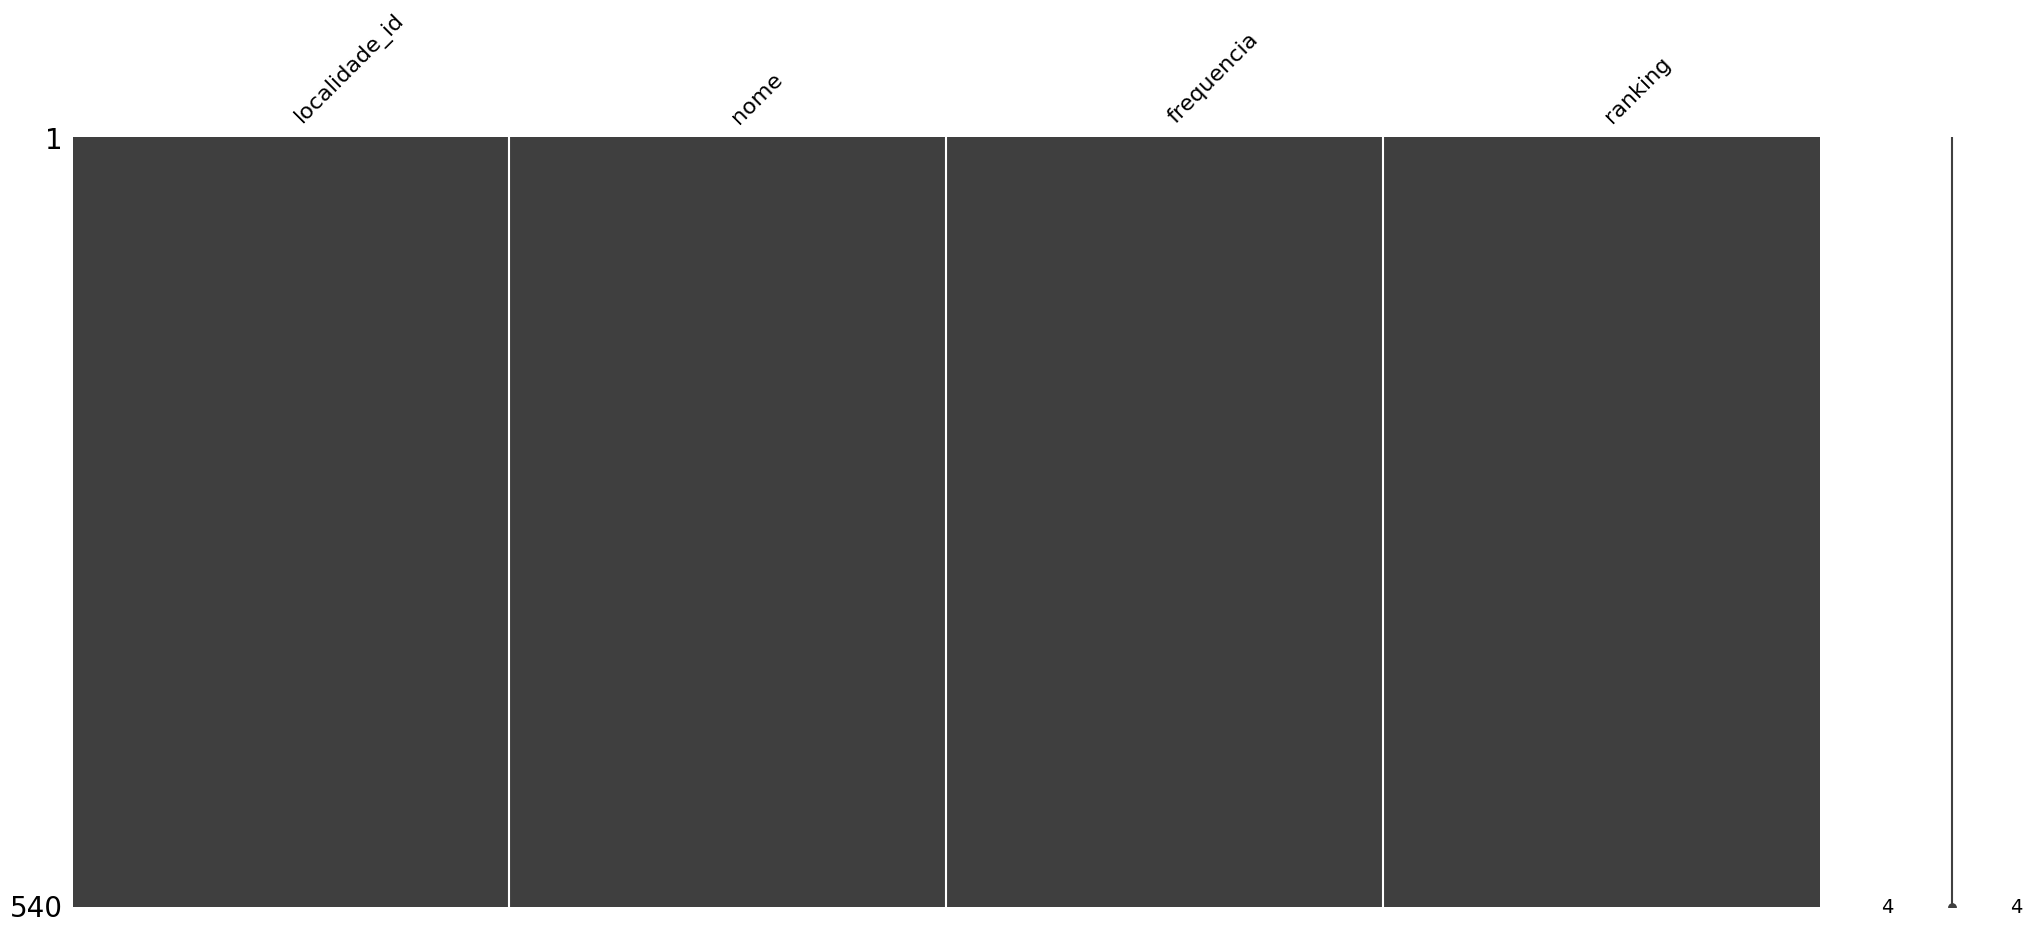

In [8]:
#Validar conteúdo dataframe df_ranking
msno.matrix(df_ranking)

<Axes: >

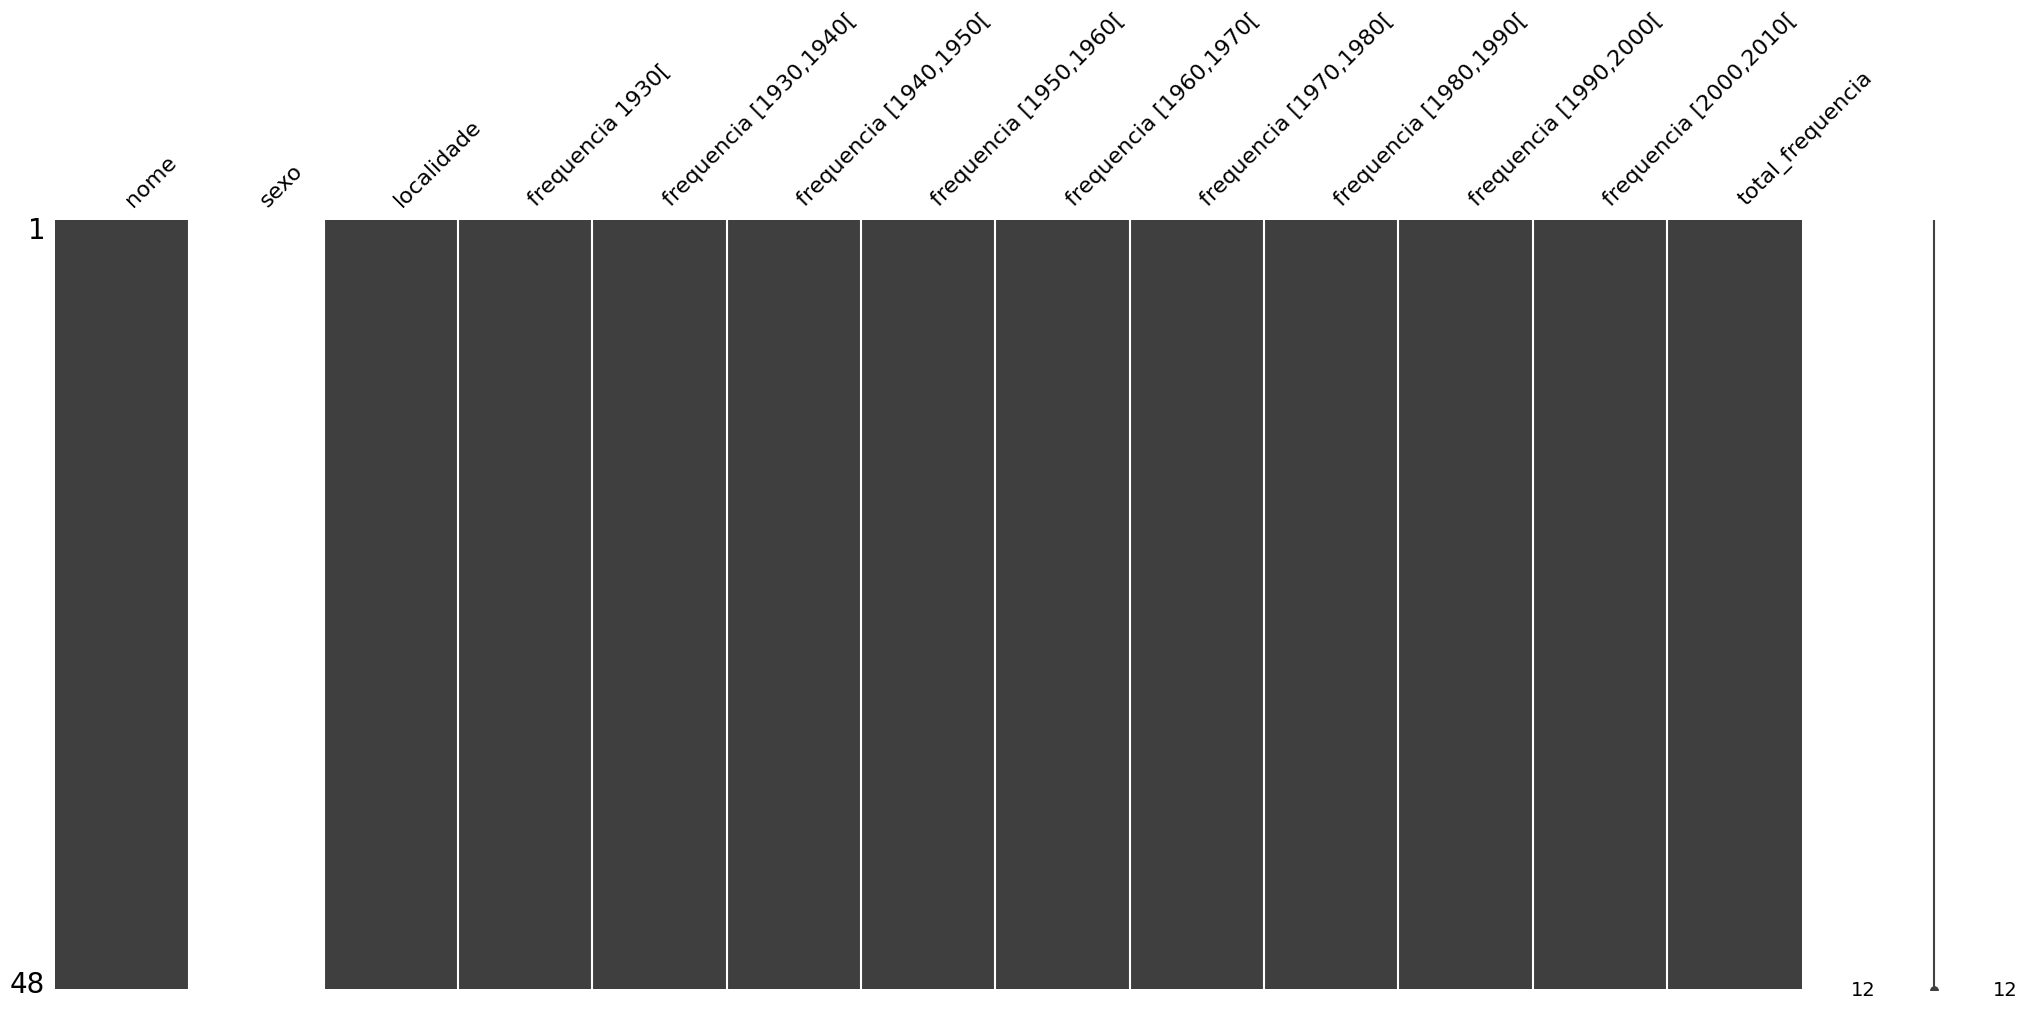

In [9]:
#Validar conteúdo dataframe df_nomes
msno.matrix(df_nomes)

<Axes: >

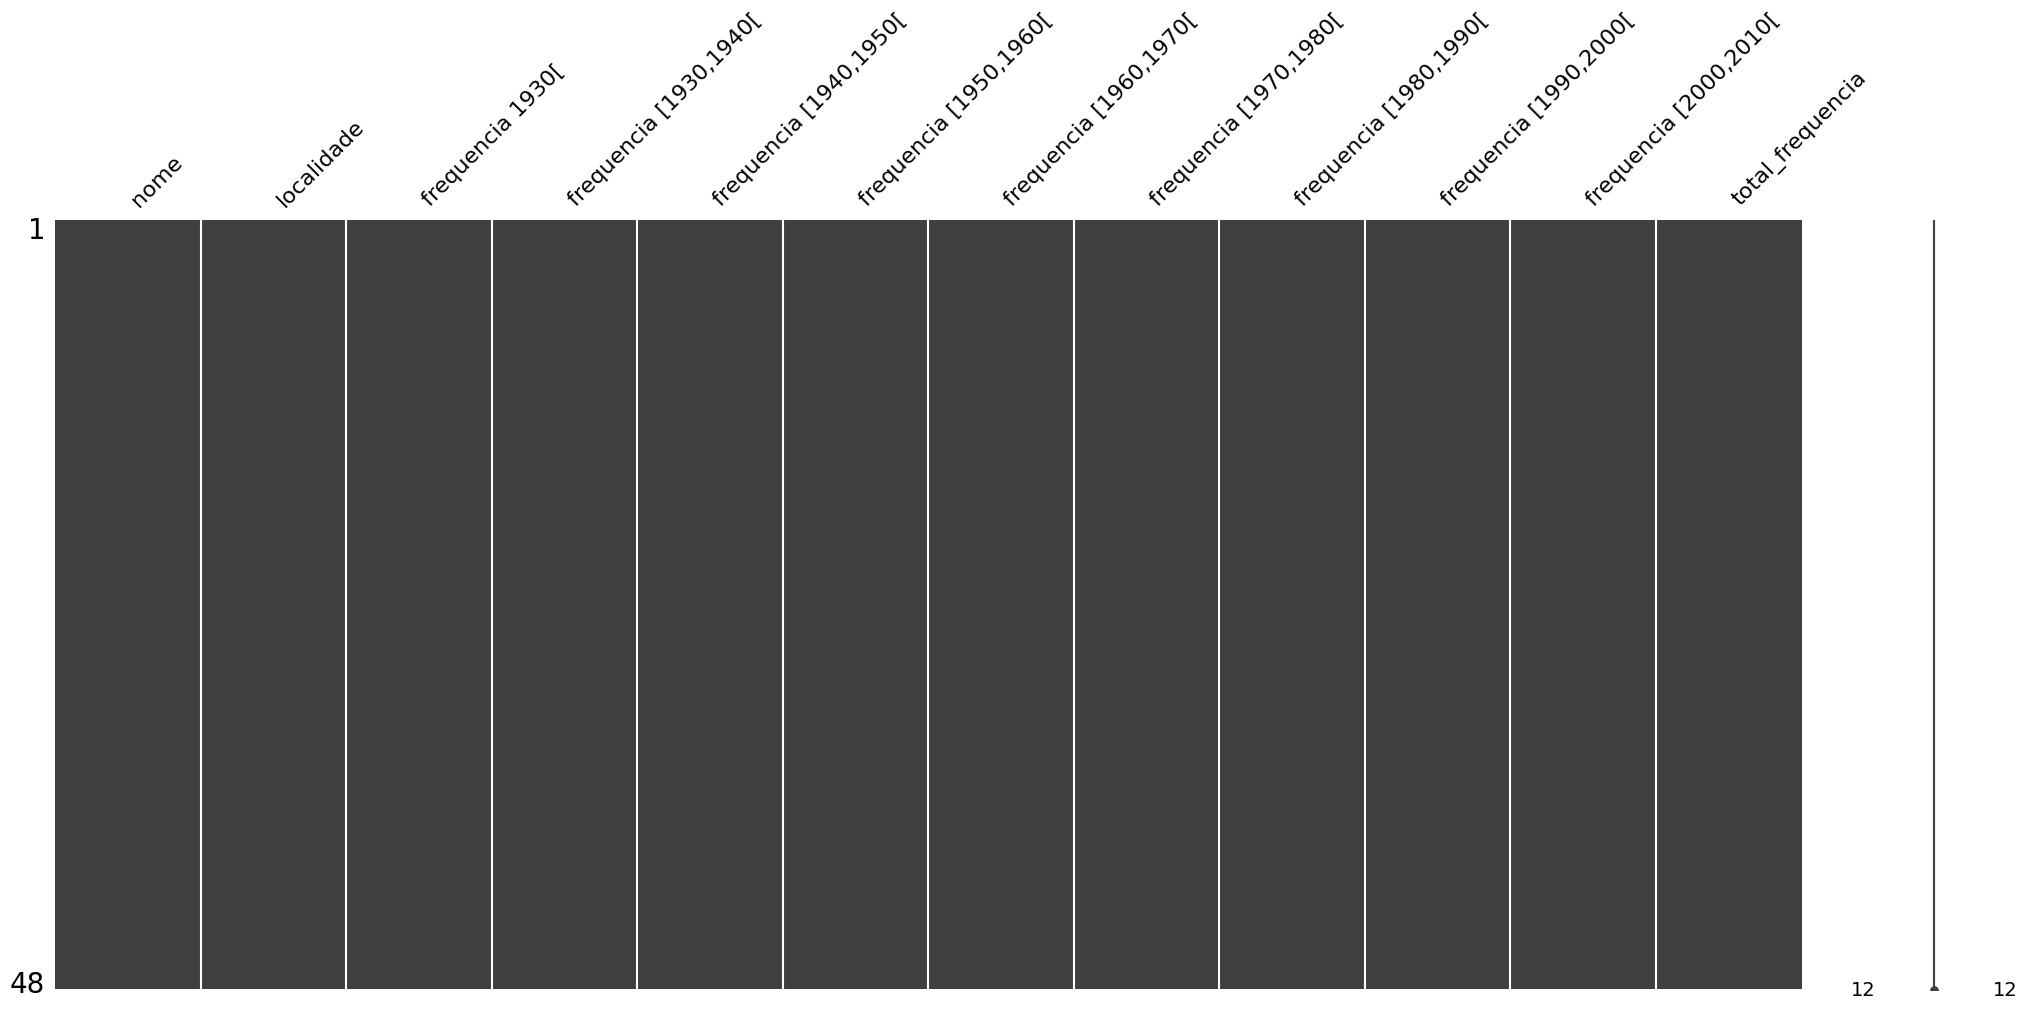

In [10]:
# Revalidando e excluindo a coluna 'sexo' devido todos os valores estarem nulos
if df_nomes['sexo'].isnull().all():
    df_nomes = df_nomes.drop(columns=['sexo'])

# Revalidando conteúdo do dataframe df_nomes após ação de exclusão da coluna
msno.matrix(df_nomes)

VI - Banco de Dados

In [11]:
# Criando Banco de Dados e Tabelas para cada DataFrame existente no Projeto

# Criação/conexão com Banco de Dados
conn = sqlite3.connect('BD_IBGE_Nomes.db')

# Salvando cada DataFrame em uma Tabela

# DataFrame df_estado para Tabela TB_Estado
df_estado.to_sql('TB_Estado', conn, if_exists='replace', index=False)

# DataFrame df_ranking para Tabela TB_Rank_Nomes
df_ranking.to_sql('TB_Rank_Nomes', conn, if_exists='replace', index=False)

# DataFram df_nomes para Tabela TB_Nome_Decada
df_nomes.to_sql('TB_Nome_Decada', conn, if_exists='replace', index=False)

# Fechando a conexão com o banco de dados
conn.close()

VII - Consulta das novas tabelas no Banco

In [12]:
#Consultando a tabelas TB_Estado do banco e realizando "filtro"/condição para exibir os dados filtrados pela região "Norte"

# Conectando ao banco de dados
conn = sqlite3.connect('BD_IBGE_Nomes.db')

# consulta tabela 'TB_Estado'
consulta_TB_Estado = '''SELECT  id ID_Estado,
                                nome Estado,
                                sigla UF,
                                regiao_nome 'Região'
                        FROM TB_Estado
                        WHERE regiao_nome = 'Norte' '''
# Gravando informação em variável temporária
temp_Estado = pd.read_sql_query(consulta_TB_Estado, conn)

# Fechando a conexão com o banco de dados
conn.close()

#apresentando o DataFrame
temp_Estado

,ID_Estado,Estado,UF,Região
0,11,Rondônia,RO,Norte
1,12,Acre,AC,Norte
2,13,Amazonas,AM,Norte
3,14,Roraima,RR,Norte
4,15,Pará,PA,Norte
5,16,Amapá,AP,Norte
6,17,Tocantins,TO,Norte


In [13]:
#Consultando as tabelas 'TB_Rank_Nomes' e 'TB_Estado' do Banco e realizando "filtro"/condição para exibir apenas os nomes que ocuparam a posição 1º nos Estados

# Conectando ao banco de dados
conn = sqlite3.connect('BD_IBGE_Nomes.db')

# consulta tabela 'TB_Rank_Nomes' e 'TB_Estado'
consulta_Nome_Estado = "SELECT ranking, TB_Rank_Nomes.nome, frequencia, regiao_nome 'Região', sigla UF, TB_Estado.nome Estado FROM TB_Rank_Nomes INNER JOIN TB_Estado ON TB_Rank_Nomes.localidade_id = TB_Estado.id WHERE ranking = 1"
temp_Nome_Estado = pd.read_sql_query(consulta_Nome_Estado, conn)

# Fechando a conexão com o banco de dados
conn.close()

temp_Nome_Estado

,ranking,nome,frequencia,Região,UF,Estado
0,1,MARIA,72579,Norte,RO,Rondônia
1,1,MARIA,63172,Norte,AC,Acre
2,1,MARIA,173034,Norte,AM,Amazonas
3,1,MARIA,20848,Norte,RR,Roraima
4,1,MARIA,472891,Norte,PA,Pará
5,1,MARIA,35298,Norte,AP,Amapá
6,1,MARIA,87040,Norte,TO,Tocantins
7,1,MARIA,574689,Nordeste,MA,Maranhão
8,1,MARIA,363139,Nordeste,PI,Piauí
9,1,MARIA,967042,Nordeste,CE,Ceará


In [14]:
#Consultando a tabela 'TB_Nome_Decada' do Banco trazendo a informação do ranking para determinada década, informada no código

# Conectando ao banco de dados
conn = sqlite3.connect('BD_IBGE_Nomes.db')

# Consulta full da tabela 'TB_Nome_Decada'
consulta_TB_Nome_Decada = "SELECT * FROM TB_Nome_Decada"
df_consulta_TB_Nome_Decada = pd.read_sql_query(consulta_TB_Nome_Decada, conn)

# Ordenando os nomes pela frequência na coluna especificada a ser informada
frequencia_pesquisada = "total_frequencia" # possível informar qualquer umas das colunas de frequência presentes na tabela
df_consulta_TB_Nome_Decada = df_consulta_TB_Nome_Decada.sort_values(by=frequencia_pesquisada, ascending=False)

# Criando uma nova coluna de ranking
df_consulta_TB_Nome_Decada['ranking'] = df_consulta_TB_Nome_Decada[frequencia_pesquisada].rank(ascending=False, method='min').astype(int)

# Selecionando apenas as colunas solicitadas
temp_consulta_TB_Nome_Decada = df_consulta_TB_Nome_Decada[['ranking', 'nome', 'localidade', frequencia_pesquisada]]

# Fechando a conexão com o banco de dados
conn.close()

# Exibir o DataFrame resultante
temp_consulta_TB_Nome_Decada


,ranking,nome,localidade,total_frequencia
0,1,MARIA,BR,11734129
1,2,JOSE,BR,5754529
3,3,ANA,BR,3089858
2,4,JOAO,BR,2984119
4,5,ANTONIO,BR,2576348
5,6,FRANCISCO,BR,1772197
8,7,CARLOS,BR,1489191
6,8,PAULO,BR,1423262
10,9,PEDRO,BR,1219605
7,10,LUCAS,BR,1127310


VIII - Exportar Tabelas para arquivos csv

> TB_Estado exportada para arquivo TB_Estados.csv

In [15]:

# Conectando ao banco de dados SQLite
conn = sqlite3.connect('BD_IBGE_Nomes.db')

# consulta tabela 'TB_Estado'
consulta1_TB_Estado = "SELECT * FROM TB_Estado"
df_TB_Estados1 = pd.read_sql_query(consulta1_TB_Estado, conn)

# Salvando o conteúdo da consulta em um arquivo CSV
df_TB_Estados1.to_csv('TB_Estados.csv', index=False)

# Fechando a conexão com o banco de dados
conn.close()

print("Conteúdo salvo no arquivo 'TB_Estados.csv'")


Conteúdo salvo no arquivo 'TB_Estados.csv'


> TB_Rank_Nomes exportada para arquivo TB_Rank_Nomes.csv

In [16]:
# Conectando ao banco de dados SQLite
conn = sqlite3.connect('BD_IBGE_Nomes.db')

# Consulta tabela 'TB_Rank_Nomes'
consulta1_TB_Rank_Nomes = "SELECT * FROM TB_Rank_Nomes"
df_TB_Rank_Nomes1 = pd.read_sql_query(consulta1_TB_Rank_Nomes, conn)

# Salvando o conteúdo da consulta em um arquivo CSV
df_TB_Rank_Nomes1.to_csv('TB_Rank_Nomes.csv', index=False)

# Fechando a conexão com o banco de dados
conn.close()

print("Conteúdo salvo no arquivo 'TB_Rank_Nomes.csv'")


Conteúdo salvo no arquivo 'TB_Rank_Nomes.csv'


> TB_Nome_Decada exportada para arquivo TB_Nome_Decada.csv

In [17]:

# Conectando ao banco de dados SQLite
conn = sqlite3.connect('BD_IBGE_Nomes.db')

# consulta tabela 'TB_Nome_Decada'
consulta1_TB_Nome_Decada = "SELECT * FROM TB_Nome_Decada"
df_TB_Nome_Decada1 = pd.read_sql_query(consulta1_TB_Nome_Decada, conn)

# Salvando o conteúdo da consulta em um arquivo CSV
df_TB_Nome_Decada1.to_csv('TB_Nome_Decada.csv', index=False)

# Fechando a conexão com o banco de dados
conn.close()

print("Conteúdo salvo no arquivo 'TB_Nome_Decada.csv'")


Conteúdo salvo no arquivo 'TB_Nome_Decada.csv'
